In [1]:
library(plyr)
source("../data/env/variables.R")
source("~/projects/wisdom/r/clean_theme.R")
library(tidyverse)
library(magrittr)
require(cowplot)
library(ggstars)
options(repr.plot.width=10, repr.plot.height=8)
library(scales)
library(UpSetR)

options("readr.num_columns" = 0)

# convert to upper case the first word
proper=function(x) paste0(toupper(substr(x, 1, 1)), tolower(substring(x, 2)))

# read switches
switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(Origin=="Tumor") %>%
    mutate(Reliable = as.numeric((NotNoise == 1) & (IsModel == 1) & (EnoughRecurrence == 1)))

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & Origin=="Tumor")
    
potus <- switches %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript, Recurrence,
           Affects_mutated_feature,PPI,Pannegative,Candidate)

drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor")) %>%
  mutate(Driver=TRUE)

# read expression
proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    set_colnames(c("Tumor","GeneId","Symbol","Transcript","TPM","ProteinLength","asEvidence")) %>%
    mutate(asEvidence = as.numeric(asEvidence=="True"))

# dictionary
id2symbol <- proteome %>%
    select(GeneId,Symbol) %>%
    unique

# protein features
features <- read_tsv("../data/mutations/proteome_features.txt") %>%
    filter(Analysis == "Pfam")

pf.all <- read_tsv("../results/pfam_enrichment_analysis.tsv")

switches.pfam <- read_tsv("../data/structural_analysis/interpro_analysis.tsv") %>%
    filter(What != "Kept") %>%
    group_by(Normal_transcript,Tumor_transcript) %>%
    summarise(DomainChange = unique(What) %>% paste0(collapse = ",")) %>%
    merge(switches.split, all.y=T)
    
# mutations
wes <- read_tsv("../data/mutations/wes_mutations.txt") %>%
    select(Tumor,GeneId,Symbol,Patient) %>%
    unique
    
# read interactions
ppi.network <- read_tsv("../data/eporta/raw_tables/interactions_found_more_than_three_times.txt", col_names = F) %>%
    select(-X3) %>%
    set_colnames(c("Gene1","Gene2")) %>%
    merge(id2symbol, by.x = "Gene1", by.y = "GeneId") %>%
    merge(id2symbol, by.x = "Gene2", by.y = "GeneId", suffixes = c("","2")) %>%
    set_colnames(c("Gene1","Gene2","Symbol1","Symbol2"))
    
ppi.file <- "../data/eporta/raw_tables/Switched_interactions_consensus.txt"

## get max number of columns (necessary for reading)
no_col <- max(count.fields(ppi.file,sep = "\t"))
no_col.ppi <- (no_col-6)/2
ppi.cols <- paste(c("Origin","Interaction"), floor(seq(1,no_col.ppi,0.5)), sep="_")

## read table
ppi.split <- read.table(ppi.file,header=F,fill=T,col.names=1:no_col) %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol",ppi.cols)) %>%
    # all Origin columns contail "DDI_match", so we can disregard them
    select(-starts_with("Origin_")) %>%
    # convert from wide to long table format
    reshape2::melt(id.vars = c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol"),
                   value.name = "Interaction") %>%
    select(-variable) %>%
    # remove cases with no interaction described
    filter(Interaction != "") %>%
    # split interaction information
    separate(Interaction, into = c("What","partnerTranscript","Pfams"), sep = "-") %>%
    mutate(What = revalue(What, replace = c("Gained"="Gain", "Lost"="Loss", "Kept"="Unaffected"))) %>%
    # remove pfams columns (account for different domains for the same interaction)
    select(-Pfams) %>%
    # remove several instances of the same isoform
    unique %>%
    # annotate with switch info
    merge(switches.split %>% filter(Reliable==1)) %>%
    ## remove tumor specific measures
    select(-Recurrence,-Affects_mutated_feature,-PPI,-Pannegative) %>%
    merge(potus, by=c('GeneId','Symbol','Normal_transcript','Tumor_transcript','Candidate'), 
          suffixes=c(".split",".pancancer")) %>%
    # consider only the most abundant isoform as partner: one interaction per pair & only expressed genes
    merge(proteome, by.x = c("Tumor","partnerTranscript"), by.y = c("Tumor","Transcript"),
          suffixes = c(".switch",".partner"))
    
ppi <- ppi.split %>%
    group_by(GeneId.switch,Symbol.switch,Normal_transcript,Tumor_transcript,GeneId.partner,partnerSymbol) %>%
    summarise(Unaffected = sum(What=="Unaffected"), Gain = sum(What=="Gain"), Loss = sum(What=="Loss")) %>%
    ungroup() %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript",
                   "partnerGeneId","partnerSymbol","Unaffected","Gain","Loss")) %>%
    mutate(Tag = ifelse(Loss > 0, "Loss", "Unaffected"),
           Tag = ifelse(Gain > Loss, "Gain", Tag)) %>%
    merge(switches)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summarise(): dplyr, plyr
summarize(): dplyr, plyr

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric

Warnin

In [2]:
# Figure 1
## Figure 1a
f1a <- switches.split %>%
    filter(Reliable==1) %>%
    mutate(Driver = ifelse(Symbol %in% drivers$Symbol, "1", "0"),
           Driver = ifelse(Driver==1, "Driver", "Non-driver"),
           Driver = factor(Driver, levels=c("Non-driver","Driver")),
           IsFunctional = ifelse(IsFunctional==1, "Functional", "Non-functional")) %>%
    ggplot(aes(x=Tumor, fill=IsFunctional, alpha=Driver)) +
        geom_bar() +
        labs(x="", y="# switches", fill="Switch", alpha="Gene") +
        scale_fill_manual(values=c("Functional"="firebrick", "Non-functional"="gray")) +
        scale_alpha_manual(values=c("Driver"=1, "Non-driver"=0.5)) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.3))

ggsave("../results/figures/components/1a.png",f1a)

Saving 7 x 7 in image


In [3]:
## Figure 1b
featsPalette = c("Gained in tumor" = "#31a354", "Lost in tumor" = "#f03b20")

# read feature changes
structuralFeatures <- '../data/structural_analysis/structural_features.onlyModels.tsv' %>%
    read_tsv %>%
    # fix some tags
    mutate(Analysis = revalue(Analysis, c("iupred"="IUPRED",
                                          "anchor"="ANCHOR",
                                          "prosite"="ProSite"))) %>%
    ## get real switches
    filter(Random=="NonRandom") %>%
    # uniq switches from different tumors
    select(-Tumor) %>% unique %>%
    # count only reliable switches
    merge(switches %>% select(Normal_transcript, Tumor_transcript))

f1b <- structuralFeatures %>%
    filter(WhatsHappenning != "Nothing") %>%
    mutate(WhatsHappenning = gsub("_", " ", WhatsHappenning)) %>%
    ggplot(aes(Analysis, fill = WhatsHappenning)) + 
        geom_bar(position="dodge") + 
        labs(y = "Counts", x = "", fill = "") +
        theme(legend.position="bottom") + 
        scale_fill_manual(values = featsPalette)

ggsave("../results/figures/components/1b.png",f1b)

Saving 7 x 7 in image


In [4]:
## Figure 1c
top.drivers <- switches %>%
    filter(Driver==1 & IsFunctional==1) %>%
    arrange(desc(PatientNumber)) %>%
    top_n(20, PatientNumber) %>%
    mutate(label = paste0(Symbol," (",Normal_transcript,",",Tumor_transcript,")")) %>%
    select(Normal_transcript,Tumor_transcript,label,Symbol)

f1c <- merge(top.drivers, switches.split) %>%
    mutate(label = factor(label, levels=top.drivers$label),
           Symbol = factor(Symbol, levels=top.drivers$Symbol)) %>%
    arrange(desc(Tumor)) %>%
    ggplot(aes(x=Symbol, y=PatientNumber, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="# patients") +
        scale_fill_manual(values=colorPalette) +
        theme(axis.text.x = element_text(angle = 90, vjust = .5))

ggsave("../results/figures/components/1c.png",f1c)

Saving 7 x 7 in image


In [5]:
## Figure 1d
cc <- read_tsv("../results/pfam_go_term/losses_GO_cellular_component.tsv",skip=15) %>%
    mutate(type="Cellular component")
mf <- read_tsv("../results/pfam_go_term/losses_GO_molecular_function.tsv",skip=15) %>%
    mutate(type="Molecular function")

go <- do.call("rbind",list(cc,mf))  %>%
    set_colnames(c("group","id","goterm","slim_level","z","p","fdr","table","domains","type")) %>%
    mutate(goterm = proper(goterm),
           numSwitches = table %>% strsplit("|", fixed=T) %>% 
               lapply(function(x) as.numeric(x[1])) %>% unlist ) %>%
    arrange(desc(numSwitches)) %>%
    filter(slim_level == 2) %>%
    top_n(15) %>%
    mutate(# break lines longer than 40 chr
           # goterm = lapply(goterm, strwrap, width = 40)  %>% lapply(paste,sep="\n", collapse="\n") %>% unlist,
           goterm = factor(goterm, levels=goterm))
                   
f1d <- ggplot(go, aes(x = 1, y = goterm, alpha = numSwitches, fill = type, label = numSwitches)) +
        geom_tile() +
        geom_text(aes(x = 1, y = goterm, label = numSwitches), inherit.aes = F) +
        labs(x = "# switches", y = "GO term", fill = "Ontology") +
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.ticks=element_blank(), axis.title.x=element_blank(),
              axis.text.y = element_text(size = 10), axis.title.y=element_blank(),
              legend.position="bottom",
              legend.text = element_text(size = 10)) +
        scale_alpha_continuous(guide=F) +
        scale_fill_manual(values = c("Cellular component"="firebrick", "Molecular function"="darkolivegreen2"), 
                          guide = guide_legend(nrow = 2, ncol = 2)) +
        scale_x_discrete(breaks=NULL)

ggsave("../results/figures/components/1d.png",f1d)

Selecting by numSwitches
Saving 7 x 7 in image


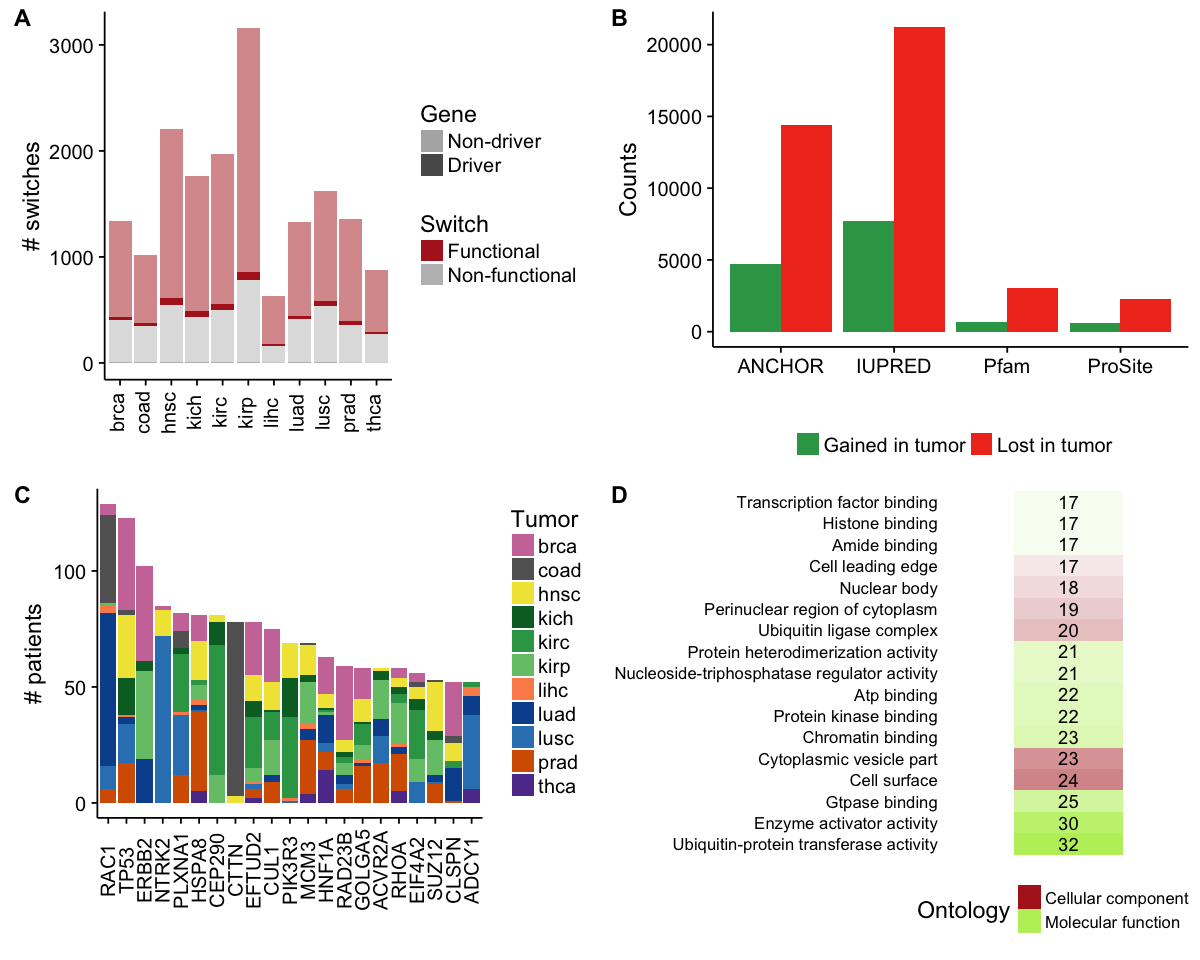

In [6]:
f1 <- plot_grid(f1a, f1b, f1c, f1d, labels=c("A","B","C","D"))
f1
ggsave("../results/figures/figure_1.png",f1, width = 10, height = 8)

Figure 1. (A) Number of switches (y axis) calculated in each tumor type (x axis), separated according to whether the switches are functional or not and whether they affect mutational drivers. The number of non-functional switches in drivers is very low in most tumor types. (B) Overlap graph of protein features affected in functional switches. (C) Functional categories associated to protein domain losses significantly enriched in functional isoform switches. For each functional category we give the number of isoform switches in which a protein domain related to this category is lost. (D) Top 50 functional switches in mutational cancer drivers according to the number of patients in which they occur. We indicate in color the tumor type. 

In [7]:
# Figure 2
## Figure 2a
# count number of genes altered per patient
## WES mutation
genesPAM.perPatient <- wes %>%
    group_by(Tumor,Patient) %>%
    summarise(PAM=length(Patient))

## a functional switch
genesSwitched.perPatient <- switches$Patients_affected[switches$IsFunctional==1] %>%
    strsplit(",") %>% unlist %>%
    table %>% as.data.frame %>%
    set_colnames(c("Patient","Switch"))

# use number of spliced genes and total number of genes to normalize the observations
lines <- "Tumor\tSplicedGenes\tGenes\nbrca\t12383\t20530\nprad\t11849\t20530\nthca\t11812\t20530\ncoad\t11498\t20530\nhnsc\t11583\t20530\nkich\t11607\t20530\nkirc\t12205\t20530\nkirp\t11853\t20530\nlihc\t10490\t20530\nluad\t12046\t20530\nlusc\t12070\t20530\n"
consideredGenes <- read_tsv(lines) %>%
    set_colnames(c("Tumor","SplicedGenes","Genes"))

recurrence <- merge(genesSwitched.perPatient,genesPAM.perPatient,all=T) %>%
    merge(consideredGenes) %>%
    mutate(PAM=PAM/Genes, Switch=Switch/SplicedGenes) %>%
    select(everything(),-contains("Genes"))

# show lack of correlation between mutations and switches
f2a <- recurrence %>%
    ggplot(aes(x=Switch,y=PAM)) + 
        geom_point(aes(color=Tumor), alpha = 0.5) + 
        scale_color_manual(values=colorPalette) + 
        labs(x="Genes with a functional switch", y="Genes with a PAM") +
        scale_y_continuous(labels = percent) +
        scale_x_continuous(labels = percent)

ggsave("../results/figures/components/2a.png",f2a)

Saving 7 x 7 in image
Warning message:
“Removed 180 rows containing missing values (geom_point).”

In [8]:
## Figure 2b
losses <- !is.na(pf.all$adjp_l) &pf.all$adjp_l < 0.05 # & pf.all$switches_l > 1
gains <- !is.na(pf.all$adjp_g) & pf.all$adjp_g < 0.05 # & pf.all$switches_g > 1
mut <- !is.na(pf.all$adjp_m) & pf.all$adjp_m < 0.05

MS.pfams <- pf.all %>%
    mutate(What = ifelse(gains,"Gains","undecided"),
           What = ifelse(losses,"Losses",What),
           What = ifelse(losses & gains,"Both",What),
           switches_g = ifelse(gains, switches_g, 0),
           switches_l = ifelse(losses, switches_l, 0),
           NumSwitches = apply(cbind(switches_g, switches_l),1,max),
           NumSwitchesLabel = ifelse(What == "Both", paste0(switches_g,"/",switches_l), NumSwitches)) %>%
    select(Feature, What, NumSwitches,NumSwitchesLabel) %>%
    filter((losses | gains) & mut) %>%
    mutate(Feature = unlist(strsplit(Feature,"|", fixed=T))[c(F,T)],
           Feature = gsub("_"," ",Feature),
           What = factor(What, levels=c("Losses","Both","Gains")))

f2b <- MS.pfams %>%
    mutate(NumSwitches = ifelse(What=="Losses", NumSwitches, -NumSwitches)) %>%
    arrange(NumSwitches) %>%
    mutate( Feature = factor(Feature, levels = unique(Feature))) %>%
    ggplot(aes(y=Feature, fill = What, alpha = abs(NumSwitches), label = NumSwitchesLabel)) +
        geom_tile(aes(x=1), stat="identity") +
        geom_text(aes(x=1), color="black", size=3.5, alpha=1) +
        scale_fill_manual(values = c("Gains" = "#e08214", "Losses" = "#8073ac", "Both" = "darkolivegreen2")) +
        facet_grid(What~., scales="free",drop=T,space="free") +
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.ticks=element_blank(), axis.title.x=element_blank(),
              axis.text.y = element_text(size=9), axis.title.y=element_blank(),
              legend.position="none")

ggsave("../results/figures/components/2b.png",f2b)

Saving 7 x 7 in image


In [9]:
## Figure 2c
# Read pfam annotation
pfam2go <- read_tsv("../data/PFAM2GO.txt",skip=1)
go.levels <- read_tsv("../data/PFAMGO.txt",skip=1)

pfam2go.m <- merge(pfam2go,go.levels) 

# Get list of all observed domains with their associated annotation
domains <- dlply(pfam2go.m, .(slim_level,GO_subontology,GO_ID), function(x){
    intersect(pf.all$id,unlist(strsplit(x[,3],",")))
}) %>% unlist 
class <- gsub("\\.[^\\.]+$", "", names(domains))

expressedgos <- unlist(strsplit(names(domains), ".", fixed=T))[c(F,F,T)] %>% 
    substr(1,10) %>%
    split(class) %>%
    lapply(unique)

# read GO term enrichment analysis and calculate an agreement between M and S
## molecular function
smf <- read_tsv("../results/pfam_go_term/S_GO_molecular_function.tsv",skip=15) %>%
    mutate(origin="switches", gotype="molecular_function")
mmf <- read_tsv("../results/pfam_go_term/M_GO_molecular_function.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="molecular_function")

## cellular component
scc <- read_tsv("../results/pfam_go_term/S_GO_cellular_component.tsv",skip=15) %>%
    mutate(origin="switches", gotype="cellular_component")
mcc <- read_tsv("../results/pfam_go_term/M_GO_cellular_component.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="cellular_component")

go <- do.call("rbind",list(smf,mmf,scc,mcc)) %>%
    set_colnames(c("group","id","goterm","slim_level","z","p","fdr","table","domains","origin","gotype")) 

all <- go %>%
    count(id,gotype,slim_level) %>%
    group_by(gotype,slim_level)  %>%
    summarise(Match = sum(n==2), Any=n())

M <- go %>% 
    filter(origin=="mutations") %>%
    count(gotype,slim_level) %>%
    mutate(M = n) %>%
    select(-n)

S <- go %>% 
    filter(origin=="switches") %>%
    count(gotype,slim_level) %>%
    mutate(S = n) %>%
    select(-n)

coincidence <- merge(all,M) %>%
    merge(S) %>%
    mutate(Match = Match/Any, sdMatch = NA, Coincidence = "Observed", 
           slim_level = revalue(as.character(slim_level),
                                replace = c('1'="Least Informative", '2'="Moderately Informative",
                                            '3'="Informative", '4'="Highly Informative")))

# prepare df to get number of samples
M <- unique(coincidence[,c('gotype','slim_level',"M","S")])

random_coincidence <- lapply(names(expressedgos), function(c){
    # select real data comparison
    studied_level <- strsplit(c, "\\.") %>% unlist
    this.slim_level <- studied_level[1]
    this.gotype <- studied_level[2]
    real_match <- coincidence %>% filter(slim_level == this.slim_level & gotype == this.gotype) %>% .$Match
    
    v <- paste(M$slim_level, M$gotype, sep=".") == c
    if (sum(v) > 0){
        x <- M %>% filter(slim_level == this.slim_level & gotype == this.gotype)
        # permutate 100 times
        permutations <- lapply(1:100, function(i){
            m <- sample(expressedgos[[c]],x$M)
            s <- sample(expressedgos[[c]],x$S)
            length(intersect(m,s))/length(unique(c(m,s)))
        }) %>% do.call("c", .)
        f <- ecdf(permutations)

        data.frame(gotype = this.gotype, slim_level = this.slim_level, 
                   Match = mean(permutations), sdMatch = sd(permutations),
                   p = 1 - f(real_match), Coincidence = "Random (x100)")
    }
}) %>% do.call("rbind", .)

p <- random_coincidence$p
        
gg <- coincidence %>%
    select(gotype, slim_level ,Match, sdMatch, Coincidence) %>%
    rbind(random_coincidence %>% select(-p)) %>%
    mutate(slim_level = factor(revalue(slim_level, 
                                       replace = c('Least Informative' = "+", 'Moderately Informative' = "++",
                                                   'Informative' = "+++", 'Highly Informative' = "++++")),
                                       levels = c('+','++','+++','++++')),
           gotype = gsub("_"," ",gotype)) %>%
    ggplot(aes(x = slim_level, y = Match, fill = gotype, alpha = Coincidence)) +
        geom_bar(position = "dodge", stat = "identity") +
        geom_errorbar(aes(ymax = Match + sdMatch, ymin = Match - sdMatch), position = "dodge") +
        scale_alpha_discrete(range = c("Observed" = 1, "Random (x100)" = 0.5)) +
        labs(x = "Information", y = "M and S agreement", fill = "GO Ontology") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_y_continuous(labels = percent) +
        ylim(0, 0.85)

f2c <- star_bar(gg, p < 0.05, arc.radius = 0.22, arc.separation = 0.025)
ggsave("../results/figures/components/2c.png",f2c)

The following `from` values were not present in `x`: 4
The following `from` values were not present in `x`: Highly Informative
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Saving 7 x 7 in image
Warning message:
“Removed 7 rows containing missing values (geom_errorbar).”

In [10]:
## Figure 2d
me <- read_tsv("../results/supplementary_files/supplementary_file_3.tsv") %>%
    filter(p_mut_ex < 0.05 & Number_ME_drivers > 2 & p_me_pathway_driver < 0.05) %>%
    select(Tumor, GeneId, Symbol, Normal_transcript, Tumor_transcript)

# read mutual exclusion with specific drivers
me.specificDrivers <- read_tsv("../data/mutations/mutual_exclusion_top_drivers.txt") %>%
    mutate(Total = M + MS + S + N, 
           M.p = M/Total, 
           MS.p = MS/Total,
           S.p = S/Total, 
           N.p = N/Total) %>%
    merge(me)

potus.pn <- switches %>%
    filter(Candidate==1 & Pannegative > 0 & Origin=="Tumor") %>%
    merge(me.specificDrivers, by=c("GeneId","Symbol","Normal_transcript","Tumor_transcript")) %>%
    filter(p.me < 0.05 & Pathway!="")

f2d <- switches %>%
    filter(Candidate==1 & Pannegative > 0 & Origin=="Tumor") %>%
    merge(me.specificDrivers, by=c("GeneId","Symbol","Normal_transcript","Tumor_transcript")) %>%
    filter(p.me < 0.05 & Pathway!="") %>%
    ggplot(aes(x = MS.p+M.p, y = MS.p+S.p, color = Tumor)) + 
        geom_point(size=0.8) +
        geom_text(data=subset(potus.pn, MS.p+S.p > 0.02), aes(label=paste0(Symbol," (",DriverSymbol,")")),
                   vjust = "inward", hjust = "inward", check_overlap = T) +
        labs(x="Mutated samples", y="Switched samples") +
        scale_color_manual(values=colorPalette) +
        guides(col = guide_legend(override.aes = list(shape = 15, size = 5))) +
        scale_y_continuous(labels = percent) +
        scale_x_continuous(labels = percent)

ggsave("../results/figures/components/2d.png",f2d)

Saving 7 x 7 in image


Warning message:
“Removed 180 rows containing missing values (geom_point).”Warning message:
“Removed 7 rows containing missing values (geom_errorbar).”

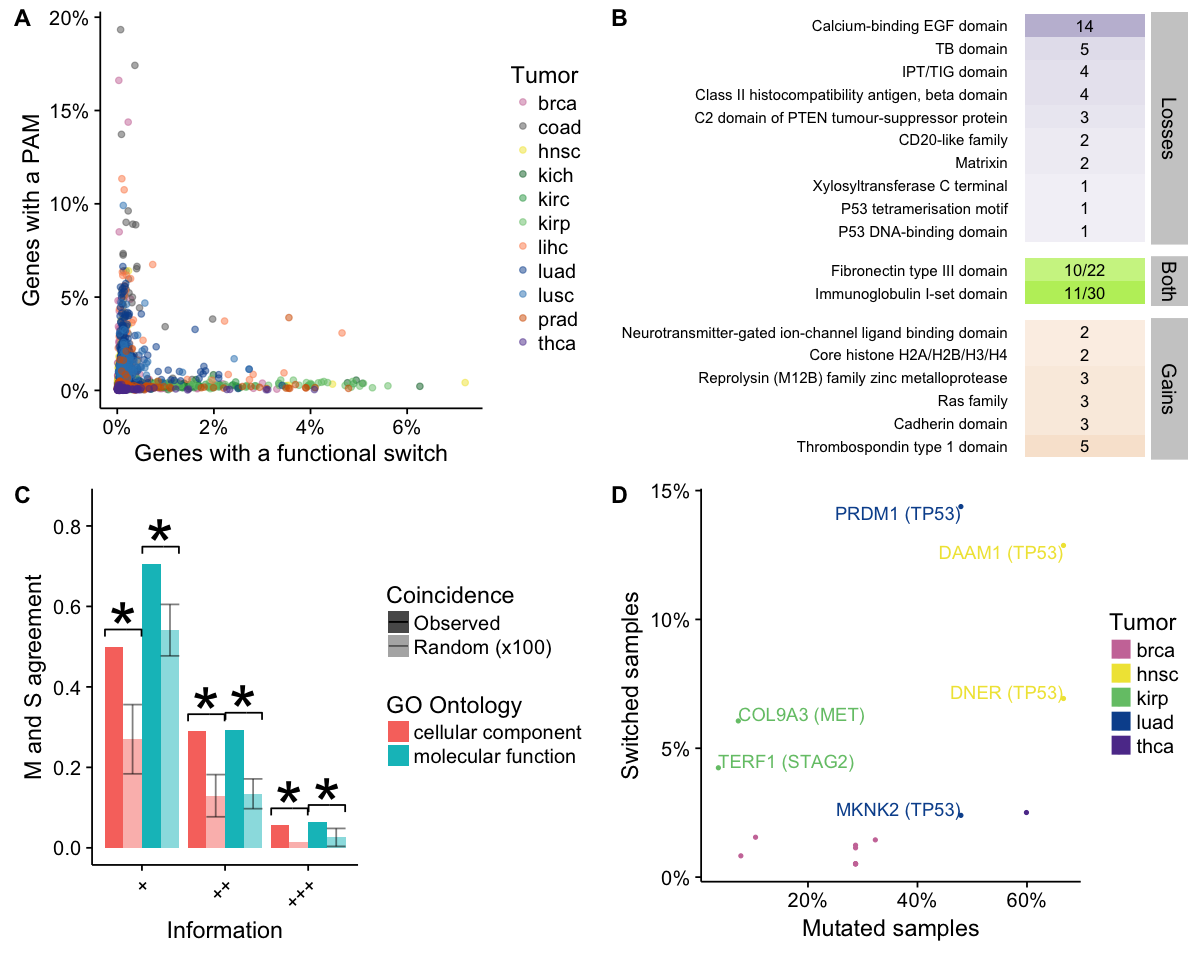

In [11]:
f2 <- plot_grid(f2a, f2b, f2c, f2d, labels=c("A","B","C","D"))
f2
ggsave("../results/figures/figure_2.png",f2, width = 10, height = 8)

**Figure 2.** (A) For each patient sample, colored according to tumor type, we indicate the proportion of all genes with protein affecting mutations (PAMs) in the sample (y axis), and the proportion of genes with multiple transcript isoforms that present a functional isoform switch in the same sample (x axis). (B) Domain classes that are are enriched in losses (left panel) or gains (right panel) in isoform switches that are also enriched in protein-affecting mutations tumors. For each domain class we indicate the number of switches (C) Agreement between protein-affecting mutations and functional switches (y axis) in terms of the functional categories of the protein domains they affect, using 3 different gene ontologies (GO) and at four different GO Slim levels, from most specific (most informative) to the least specific (least informative). Random occurrences were calculated by sampling 100 times the same number of domain classes affected by functional switches or by protein-affecting mutations. (D) Pairs formed by a mutational driver and a functional isoform switch that belong to the same functional pathway and show mutual exclusion of PAMs and switches across patients in at least one tumor type (color coded by tumor type). The graph indicates the percentage of samples where the switch occurs (x axis) and the percentage of samples where the driver is mutated in the same tumor type. Each pair is represented with the gene symbol that has the switch and the mutational driver gene symbol (in parenthesis). 

In [12]:
# Figure 3
ppiPalette = c("Gain" = "#31a354", "Loss" = "#f03b20", "Unaffected" = "#d9d9d9", "Draw" = "#d9d9d9")

## Figure 3a
f3a <- ppi.split %>%
    mutate(SpecificDriver = ifelse(SpecificDriver==1, "Yes", "No")) %>%
    ggplot(aes(x=SpecificDriver, fill=What)) + 
        geom_bar(position="fill") +
        labs(x="Tumor-specific driver",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 90, vjust = 0.3),
              strip.text.x = element_text(size = 9)) +
        scale_y_continuous(labels = percent) +
        facet_grid(.~Tumor)

ggsave("../results/figures/components/3a.png",f3a)

Saving 7 x 7 in image


In [13]:
## Figure 3b
driver.ppi.network <- ppi.network %>%
    filter(Symbol1 %in% drivers$Symbol | Symbol2 %in% drivers$Symbol)

d1 <- lapply(cancerTypes, function(tumor){
    tumor.drivers <- drivers %>%
        filter(Tumor == tumor)
    
    driver.ppi.network %>%
        mutate(Symbol1 = ifelse(Symbol1 %in% tumor.drivers$Symbol, "", Symbol1),
               Symbol2 = ifelse(Symbol2 %in% tumor.drivers$Symbol, "", Symbol2)) %>%
        # get cases with one driver
        filter(Symbol1 == "" | Symbol2 == "") %>%
        # remove cases with two drivers
        filter(Symbol1 != "" | Symbol2 != "") %>%
        mutate(Symbol = paste0(Symbol1, Symbol2),
               Tumor = tumor, d1 = TRUE) %>%
        select(Symbol, Tumor, d1)
}) %>% do.call("rbind",.)

f3b <- switches.split %>%
    filter(Reliable == 1) %>%
    merge(d1, all.x = T) %>%
    mutate(d1 = ifelse(is.na(d1), FALSE, d1),
           Gene = ifelse(d1,"Driver interactor","Other"),
           Gene = ifelse(SpecificDriver == 1, "Driver", Gene),
           PPI = ifelse(PPI == 1, "Yes", "No")) %>%
    select(Tumor, Gene, PPI) %>%
    ggplot(aes(x = PPI, fill = Gene)) +
        geom_bar(position = "fill") +
        labs(y = "Switches", x = "Affects PPI") +
        theme(legend.position = "bottom", axis.text.x = element_text(angle = 90, vjust = 0.4),
              strip.text.x = element_text(size = 9) ) +
        scale_y_continuous(labels = percent) +
        scale_fill_manual(values = c("Driver" = "black", "Driver interactor" = "gray70", "Other" = "gray90")) +
        facet_grid(.~Tumor)

ggsave("../results/figures/components/3b.png",f3b)

Saving 7 x 7 in image


In [14]:
## Figure 3c
source("../data/env/getPPINetwork.R")
library(ggnetwork)

SPLICEOSOME <- c("CNBP","IPO13","RSL1D1","HNRNPU","HNRNPF","UBE2E3","DHX15","NHP2L1","RBM39",
             "RBMX","RBM11","TARDBP","EEF1A1","EEF1D","DDX5","PABPC1","UBE2E1","SFRS6",
             "HNRNPD","CHD1","RBM7","SYNCRIP","EEF1A2","PSPC1","SFRS11","HNRNPR","MAPK9",
             "CLK3","RNF167","GAS7","SUMO1","HNRNPA1","SF1","RBM25","SFRS4","MYB","BMPR1A",
             "TRA2B","HNRNPC","RBMS2","SFRS7","RPL31","WBP4","SFRS13A","PTBP1","HNRNPM",
             "SNRNP70","SNRPA","EWSR1","TDRD3","RNPS1","SFRS1","ZMYND11","NUDT21","CDK11B",
             "VARS","BTRC","CPSF6","ELAVL1","NXT1","PRPF8","NUP98","PRPF4","SFRS3","NXF1","SAE1",
             "RBM41","HNRNPA0","SUMO2","SFRS9","SF3B4","YBX1","SRPK1","RAN","HNRPDL","MKI67IP","THOC4",
             "TCERG1","U2AF2","EIF4H","FBL","MAGOH","HNRNPH1","SFPQ","SUMO3","SFRS5","TNPO1","NUP133",
             "UBA2","FUS","HNRNPA3","DDX17","SFRS2","PUF60","IPO11","THRA","HNRNPA2B1","PCBP1","SF3B1",
             "UBE2I","CDK19","EIF6","TNPO3","SNRPD2","CIRBP","TRA2A","RBBP6","NONO","TNPO2","SF3B2",
             "DUSP11","U2AF1","SF3B14","SFRS12","NUTF2","KPNA3","SNRPB2","KHDRBS2")
SPLICEOSOME <- id2symbol %>%
    filter(Symbol %in% SPLICEOSOME) %>%
    .$GeneId

currentSymbols <- c('IPO13','NXF1','TDRD3','HNRNPC','RNPS1','FUS','THRA','SFRS1','PTBP1',
                    'SNRPB2','NHP2L1','UBE2E1','CNBP','TRA2B','HNRNPD','IPO11','HNRNPH1',
                    'SYNCRIP','PUF60','PRPF4','RBM41','DDX5','SF1','RBMS2','SFRS2','SRPK1',
                    'TRA2A','PABPC1','RBMX')
ppi.filt <- ppi %>%
    filter(Symbol %in% currentSymbols)

nw <- getPPINetwork(SPLICEOSOME, ppi.network, ppi.filt)

# add node attributes
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% ppi.filt$Symbol, "Switch", "Non-switch")
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers$Symbol, 
                        paste0(nw %v% "Gene", " driver"), paste0(nw %v% "Gene", " non-driver"))

f3c <- ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
    geom_edges(aes(color = Effect, linetype = Consensus)) +
    geom_nodelabel(aes(label = vertex.names, fill = Gene), size = 3, color = "white") +
    scale_color_manual(values = ppiPalette) +
    scale_fill_manual(values = c("Switch driver" = "#404040", "Non-switch driver" = "#bababa",
                                 "Switch non-driver" = "#2c7bb6", "Non-switch non-driver" = "#abd9e9"),
                      guide = guide_legend(nrow = 2, ncol = 2)) +
    scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed"), guide = "none") +
    lims( x = c(-.10, 1.10)) + 
    theme(axis.line=element_blank(),axis.text.x=element_blank(),
          axis.text.y=element_blank(),axis.ticks=element_blank(),
          axis.title.x=element_blank(),axis.title.y=element_blank(),
          legend.position="bottom") +
    guides(color = FALSE)

ggsave("../results/figures/components/3c.png",f3c)

network: Classes for Relational Data
Version 1.13.0 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


Attaching package: ‘network’

The following object is masked from ‘package:plyr’:

    is.discrete


Attaching package: ‘igraph’

The following objects are masked from ‘package:network’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex.attributes,
    set.edge.attribute, set.vertex.attribute

The following object is masked from ‘package:magrittr’

In [15]:
## Figure 3d
source("../data/env/getAffected.R")
library(find.me)

# filter out patients without RNAseq data available
rnaseqPatients <- strsplit(switches$Patients_affected,",") %>% unlist %>% unique
mutations <- wes %>%
  filter(Patient %in% rnaseqPatients) %>%
  mutate(Alteration2="MUT")

pannegative <- merge(wes,drivers,all.x=T) %>%
  mutate(Driver = ifelse(is.na(Driver), FALSE, TRUE)) %>%
  group_by(Patient) %>%
  summarise(Pannegative = ifelse(sum(Driver), "Mut+", "Mut-"))

# mutations in drivers
driver.mutations <- mutations %>%
  filter(Symbol %in% drivers$Symbol)

SPLICEOSOME.net <- nw %v% "vertex.names"

ppi.onco <- ppi.filt %>%
    group_by(GeneId, Symbol, Normal_transcript, Tumor_transcript) %>%
    summarise(PPIChange = unique(Tag) %>% paste(collapse = ",")) %>%
    merge(switches.split %>% filter(Symbol %in% currentSymbols), all.y = T) %>%
    mutate(PPIChange = ifelse(is.na(PPIChange), "Unaffected", PPIChange))

affected <- getAffected(SPLICEOSOME.net, ppi.onco, driver.mutations)
affectedWide <- affected$wide
affectedLong <- affected$long

ngenes_3d <- nrow(affectedWide)
# SPLICING: amp for losses, del for gains, down for any functional
plot.colors <- c(colorPalette, "amp" = "#f03b20", "del" = "#31a354", "downreg" = "gray70", 
                 "somatic" = "#36454F", "Mut+" = "black", "Mut-" = "gray80", "MutUnknown"="white")

patients <- affectedLong %>% 
  select(Tumor,Patient) %>%
  unique %>%
  merge(pannegative,all.x=T) %>%
  mutate(Pannegative = ifelse(is.na(Pannegative), "MutUnknown", Pannegative))

f3d <- oncoprint(affectedWide) + 
  geom_tile(data = patients, aes(x = Patient,y = ngenes_3d + .75, fill = Tumor), height=0.3) +
  geom_tile(data = patients, aes(x = Patient, y = ngenes_3d + .55, fill = as.character(Pannegative)), height=0.1) +
  labs(x="", y="") + 
  theme(axis.text.x=element_blank(), 
        # remove grid 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
  scale_fill_manual(values = plot.colors)
  
ggsave("../results/figures/components/3d.png",f3d)

Loading required package: reshape2

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Warning message:
“Ignoring unknown aesthetics: width, height”Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Saving 7 x 7 in image


In [16]:
## Figure 3e
post.splicing <- c("EEF1A1","PABPC1","EIF1","EIF2B1","EIF2B2","EIF2B3","EIF2B4","EIF2B5",
                   "EIF2S1","EIF2S2","EIF2S3","EIF3A","EIF3B","EIF3C","EIF3D","EIF3E","EIF3F",
                   "EIF3G","EIF3H","EIF3I","EIF3J","EIF4A2","EIF4A3","EIF4B","EIF4E",
                   "EIF4EBP1","EIF4G1","EIF5","EIF5B")
post.splicing <- id2symbol %>%
    filter(Symbol %in% post.splicing) %>%
    .$GeneId

currentSymbols <- c("EIF3A","EIF4B","EIF5","EIF3C","EIF2B4","EIF2B5","EIF4A2",
                    "EEF1A1","EIF3B","PABPC1","EIF3E","EIF4A3","EIF4E")
ppi.filt <- ppi %>%
    filter(Symbol %in% currentSymbols)

nw <- getPPINetwork(post.splicing, ppi.network, ppi.filt)

# add node attributes
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% ppi.filt$Symbol, "Switched", "Unswitched")
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers$Symbol, 
                        paste0(nw %v% "Gene", " driver"), paste0(nw %v% "Gene", " non-driver"))

f3e <- ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
    geom_edges(aes(color = Effect, linetype = Consensus)) +
    geom_nodelabel(aes(label = vertex.names, fill = Gene), size = 5, color = "white") +
    scale_color_manual(values = ppiPalette) +
    scale_fill_manual(values = c("Switched driver" = "#404040", "Unswitched driver" = "#bababa",
                                 "Switched non-driver" = "#2c7bb6", "Unswitched non-driver" = "#abd9e9"),
                      guide = guide_legend(nrow = 2, ncol = 2)) +
    scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed"), guide = "none") +
    lims( x = c(-.10, 1.10)) + 
    theme(axis.line=element_blank(),axis.text.x=element_blank(),
          axis.text.y=element_blank(),axis.ticks=element_blank(),
          axis.title.x=element_blank(),axis.title.y=element_blank(),
          legend.position="bottom") +
    guides(color = FALSE)

ggsave("../results/figures/components/3e.png",f3e)

Saving 7 x 7 in image


In [17]:
## Figure 3f
post.splicing.net <- nw %v% "vertex.names"

ppi.onco <- ppi.filt %>%
    group_by(GeneId, Symbol, Normal_transcript, Tumor_transcript) %>%
    summarise(PPIChange = unique(Tag) %>% paste(collapse = ",")) %>%
    merge(switches.split %>% filter(Symbol %in% currentSymbols), all.y = T) %>%
    mutate(PPIChange = ifelse(is.na(PPIChange), "Unaffected", PPIChange))

affected <- getAffected(post.splicing.net, ppi.onco, driver.mutations)
affectedWide <- affected$wide
affectedLong <- affected$long

affectedLong <- affectedLong %>%
    filter(Patient %in% colnames(affectedWide))

ngenes_3f <- nrow(affectedWide)

patients <- affectedLong %>% 
  select(Tumor,Patient) %>%
  unique %>%
  merge(pannegative,all.x=T) %>%
  mutate(Pannegative = ifelse(is.na(Pannegative), "MutUnknown", Pannegative))

f3f <- oncoprint(affectedWide) + 
  geom_tile(data = patients, aes(x = Patient,y = ngenes_3f + .75, fill = Tumor), height=0.3) +
  geom_tile(data = patients, aes(x = Patient, y = ngenes_3f + .55, fill = as.character(Pannegative)), height=0.1) +
  labs(x="", y="") + 
  theme(axis.text.x=element_blank(), 
        # remove grid 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
  scale_fill_manual(values = plot.colors)

ggsave("../results/figures/components/3f.png",f3f)

Warning message:
“Ignoring unknown aesthetics: width, height”Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Saving 7 x 7 in image


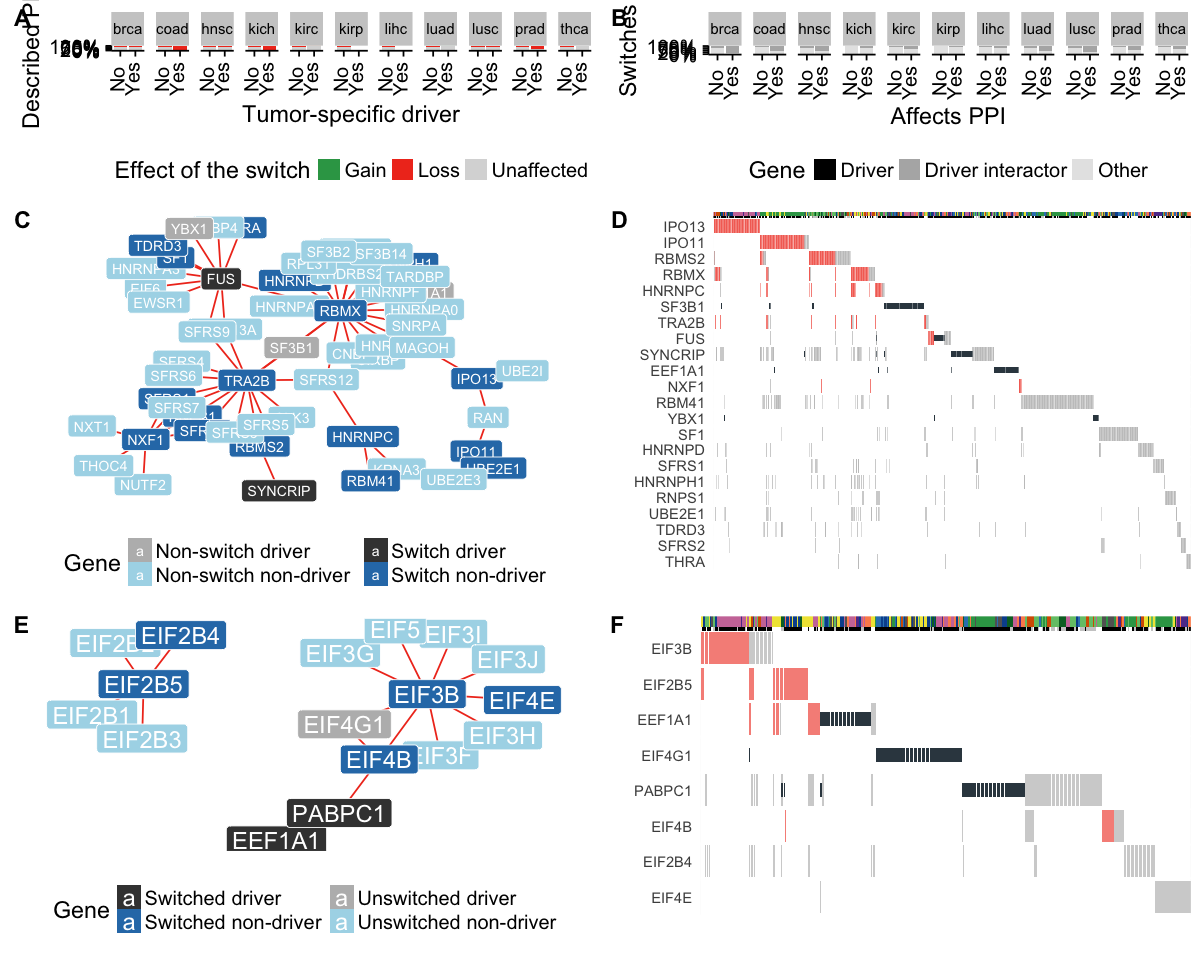

In [18]:
f3 <- cowplot::plot_grid(f3a, f3b, f3c, f3d, f3e, f3f, labels=c("A","B","C","D","E","F"), 
                         nrow = 3, ncol = 2, rel_heights = c(0.7, 1.4, 1.2))
f3
ggsave("../results/figures/figure_3.png",f3, width = 10, height = 15)

**Figure 3.** Protein-protein interactions (PPIs) involving mutational cancer drivers that are affected by switches. **(A)** Switches in tumor-specific driver genes tend to alter interactions more frequently than those in other genes (Fisher’s exact test p-value < 0.02, odds-ratio = 1.37). We divide functional switches according to whether they occur in tumor-specific drivers (HC-driver) or not (Non-driver). In each subset we plot the proportion of PPIs kept intact (gray), lost (red) or gained (green). **(B)** Switches that affect frequently mutated protein features or that are highly recurrent also have a higher proportion of interactions affected compared to the rest of the switches. Functional switches are divided according to whether they are recurrent (Yes) or not (No), or according to whether they affect domains frequently mutated in cancer (M feature) (Yes) or not (No). In each subset we plot the proportion of PPIs kept intact (gray), lost (red) or gained (green). **(C)** The network shows the protein-protein interactions (PPIs) of SF3B1. In red we indicate those interactions that are lost by isoform switches. In gray we indicate those interactions that are not affected. **(D)** Oncoprint depicting the samples where SF3B1 presents protein-affecting mutations (PAMs) together with the samples where SF3B4, HNRNPR, RBMX and TRA2B have switches that affect the protein interactions with SF3B1. Mutations are indicated in black, whereas switches that give rise to losses are indicated in red. The panel above indicate the tumor type of each sample by color. The second panel indicates whether each sample harbors a PAM in a tumor-specific driver (red) or not (gray). In white we indicate that no mutation data is available for that sample. **(E)**  (E) Sames as (C) for the driver YY. **(F)** Oncoprint for YY and interactors that have switches and affect the PPI with YY. 

In [19]:
f4a <- switches.split %>%
    filter(Reliable == 1 & IsFunctional == 1) %>%
    mutate(Candidate = ifelse(Candidate == 1, "AS Driver", "Other")) %>%
    ggplot(aes(x = Tumor, fill = Candidate)) +
        geom_bar() +
        labs(fill = "Functional switches", y = "# switches") +
        scale_fill_manual(values=c("AS Driver"="#2e3268", "Other" = "#989479")) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.3))
ggsave("../results/figures/components/4a.png",f4a)

Saving 7 x 7 in image


In [20]:
potus <- switches %>%
    filter(Candidate==1 & Origin=="Tumor") %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript)

# check that all the patients have at least one switch/mutation
alterationsPerPatient <- lapply(cancerTypes, function(tumor){
  
    # read switches
    tumor.potus <- switches.split %>%
        filter(Tumor==tumor) %>%
        merge(potus)
  
    ## count number of AS drivers switched per patient
    patients <- tumor.potus$Patients_affected %>% strsplit(",") %>% unlist
    switchesPerPatient <- plyr::count(patients) %>%
        set_colnames(c("Patient","Switches"))
  
    # read mutations  
    ## get cancer specific drivers
    tumor.drivers <- drivers$Symbol[drivers$Tumor==tumor]
   
    ## filter out mutations not in drivers
    mutations.drivers <- wes %>%
        filter(Tumor == tumor) %>%
        filter(Symbol %in% tumor.drivers) %>%
        ## consider only mutated genes, not several mutations in a gene
        select(GeneId,Patient) %>%
        unique
    
    ## count number of mutations per patient
    mutationsPerPatient <- plyr::count(mutations.drivers$Patient) %>%
        set_colnames(c("Patient","Mutations"))
    
    # get patients with both RNAseq and mutation information
    patients.swt <- unique(patients)
    patients.mut <- unique(wes$Patient)
    patients.common <- intersect(patients.swt,patients.mut)
    
    merge(mutationsPerPatient,switchesPerPatient, all=T) %>%
        mutate(Switches = ifelse(is.na(Switches), 0, Switches ),
               Mutations = ifelse(is.na(Mutations), 0, Mutations),
               Tumor = tumor,
               Class = ifelse(Mutations/length(tumor.drivers) < Switches/nrow(tumor.potus), "S", "M")) %>%
        filter(Patient %in% patients.common)
  
}) %>% do.call("rbind",.)

svg("../results/figures/components/4b.svg")
f4b <- switches %>%
    filter(Candidate==1) %>%
    select(Recurrence,Affects_mutated_feature,PPI,Pannegative) %>%
    rename(Affects_M_feature = Affects_mutated_feature) %>% 
    mutate(Pannegative = ifelse(Pannegative > 2, 1,0)) %>%
    as.data.frame %>%
    upset(order.by = "freq", nintersects = 9, line.size = 2.5, point.size = 7,
          mainbar.y.label = "# switches", sets.x.label = "# switches", show.numbers = FALSE,
          text.scale = c(2,2,2,2,2,1))
dev.off()

pdf 
  2

In [21]:
## Figure 4b
total <- alterationsPerPatient %>%
    plyr::count('Tumor') %>% 
    set_colnames(c("Tumor","Patients"))

tumorClassification <- alterationsPerPatient %>%
    plyr::count(c('Class','Tumor')) %>%
    set_colnames(c("Class","Tumor","Counts")) %>%
    merge(total) %>%
    mutate(Prop = Counts/Patients, Class = factor(Class, levels=c("S","M")),
           Tumor = factor(Tumor, levels=Tumor[Class=="S"][order(-Prop[Class=="S"])]))

f4c <- ggplot() + 
    geom_bar(data = subset(tumorClassification, Class=="S"),aes(x=Tumor,y=Prop,fill=Tumor),stat="identity") +
    geom_bar(data = subset(tumorClassification, Class=="M"),aes(x=Tumor,y=-Prop,fill=Tumor),stat="identity") +
    geom_text(aes(x=10,y=.85,label="Splicing"), size=5) +
    geom_text(aes(x=2,y=-.85,label="Mutations"), size=5) +
    geom_hline(yintercept = 0) +
    scale_fill_manual(values=colorPalette) +
    labs(y="Relevance", x="") +
    scale_y_continuous(labels = percent) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.4),
          legend.position="none")

ggsave("../results/figures/components/4c.png",f4c)

Saving 7 x 7 in image


In [22]:
## Figure 4d
f4d <- ggplot(alterationsPerPatient,aes(x=Switches,y=Mutations,color=Tumor)) + 
    geom_point(size=2) + 
    labs(x="AS-drivers switched",y="Mut-drivers mutated") +
    scale_color_manual(values=colorPalette)

ggsave("../results/figures/components/4d.png",f4d)

Saving 7 x 7 in image


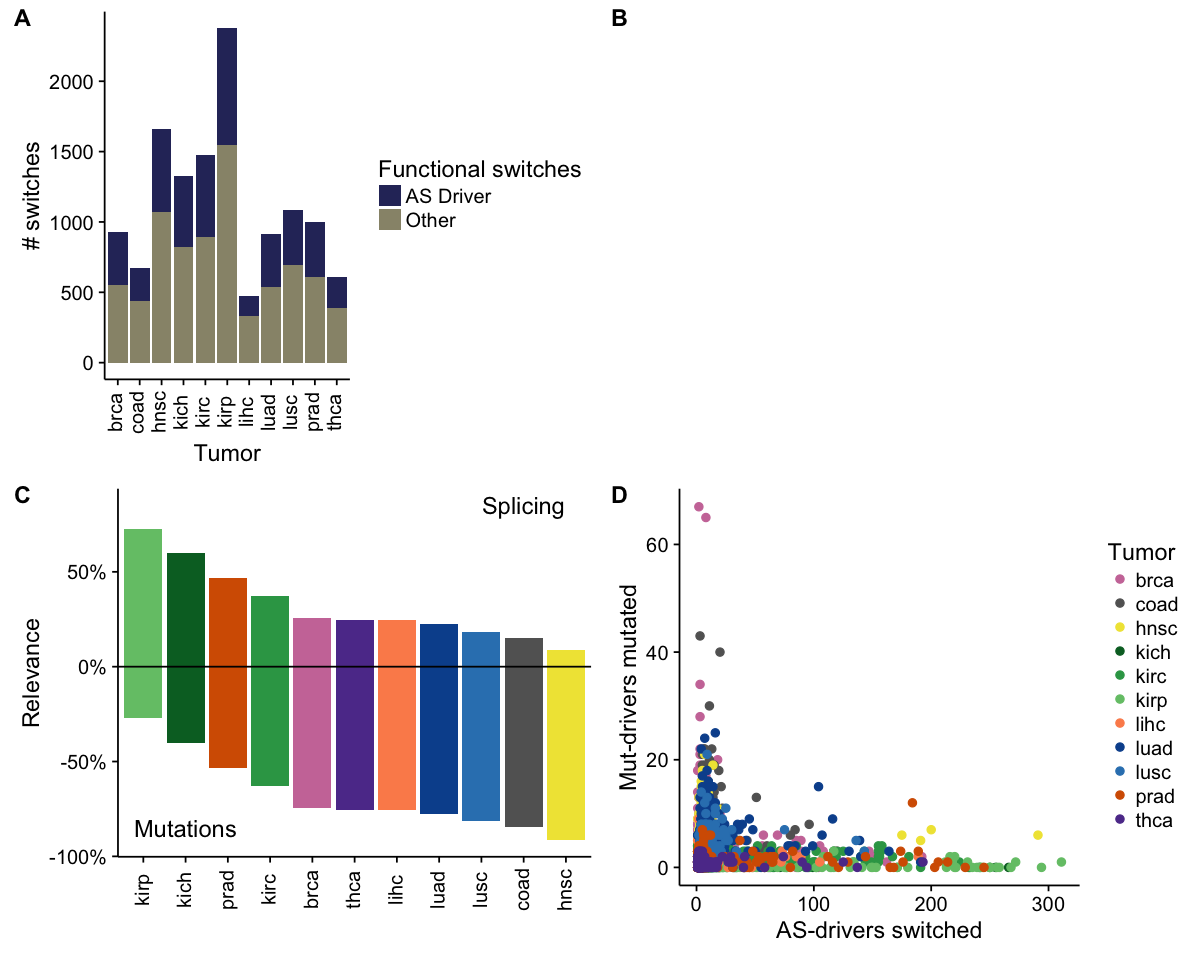

In [23]:
f4 <- cowplot::plot_grid(f4a, f4b, f4c, f4d, labels=c("A","B","C","D"))
f4
ggsave("../results/figures/figure_4.png",f4, width = 10, height = 8)

**Figure 4. (A)** Candidate alternative splicing drivers (AS-drivers) grouped according to their properties: disruption of protein-protein interactions (PPI), recurrence across patients (Methods), gain or loss of a protein feature that is frequently mutated in tumors (affects_mutated_feature), shows mutual exclusion with a Mut-driver in the same pathway (DriverME), and it shows mutual exclusion with a set of drivers  **(B)** Classification of samples according to AS-driver or Mut-driver enrichment in each tumor type. Given the set of tumor specific mutational drivers (Mut-drivers) and our set of pan-cancer switches (AS-drivers) (Supp. Table XX), we represent for each tumor type (x axis) the proportion of samples that have a proportion of mutated Mut-drivers greater than the proportion of switches in AS-drivers (positive y-axis). Similarly, we represent in the negative y-axis the proportion of samples where the proportion of switches in AS-drivers is greater than the proportion of mutated Mut-drivers. **(C)** Every patient sample is represented according to the proportion of mutated Mut-drivers (y-axis) and the proportion of switched AS-drivers (x-axis). The number of sample at a position of the plot range from 0 (white) to XXX (dark blue). 